In [1]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing

In [2]:
df = pd.read_csv('MillionSongs_Spotify_LastFM/Music_Info.csv')

In [3]:
df.head()

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


Text(0.5, 1.0, 'Songs Over Time')

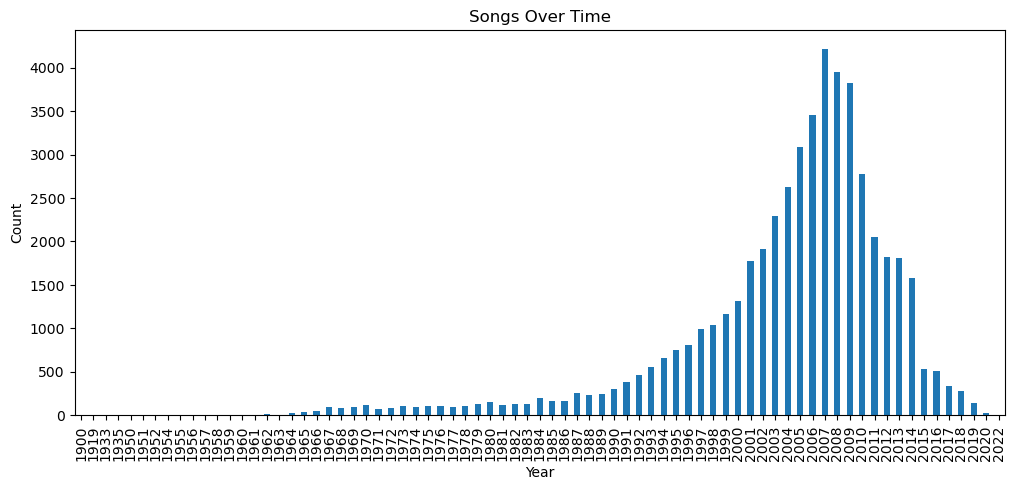

In [4]:
fig = df['year'].value_counts().sort_index().plot(kind="bar", figsize=(12,5))

fig.set_xlabel("Year")
fig.set_ylabel("Count")
fig.set_title("Songs Over Time")

In [5]:
df['valence'] = df['valence'].apply(lambda x: (1-(-1)) * ((x - 0)/(1-0)) + 1)
df['energy'] = df['energy'].apply(lambda x: (1-(-1)) * ((x - 0)/(1-0)) + 1)

In [6]:
model_df = df.drop(columns=['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'tags', 'genre', 'year', 'duration_ms'])

model_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'],
      dtype='object')

In [7]:
model_df.isnull().values.any()

np.False_

In [8]:
column_means = {}

y = np.array(df[['valence', 'energy']])

single_feature_pred = model_df.drop(columns=['valence', 'energy'])

for col1 in single_feature_pred.columns:

    X = np.array(df[[col1]])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

    model = MultiOutputRegressor(LinearRegression())

    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    column_means[f"valence_{col1}"] = [y_test[:, 0], predictions[:, 0]]
    column_means[f"energy_{col1}"] = [y_test[:, 1], predictions[:, 1]]

In [ ]:
best_single_valence = ""
best_single_arousal = ""

val_min_mean_squared = float('inf')
en_min_mean_squared = float('inf')

for vars, vals in column_means.items():
    mse = mean_squared_error(vals[0], vals[1])
    mae = mean_absolute_error(vals[0], vals[1])

    if "valence" in vars and mse < val_min_mean_squared:
        val_min_mean_squared = mse
        best_single_valence = vars[vars.find("_") + 1:]
    elif "energy" in vars and mse < en_min_mean_squared:
        en_min_mean_squared = mse
        best_single_arousal = vars[vars.find("_") + 1:]

print(f"{best_single_valence}: {val_min_mean_squared}")
print(f"{best_single_arousal}: {en_min_mean_squared}")

danceability: 0.1892897435659757
loudness: 0.09927277815814743


In [11]:
column_means = {}

y = np.array(df[['valence', 'energy']])

dual_feature_pred = model_df.drop(columns=['valence', 'energy'])

for col1 in dual_feature_pred.columns:
    for col2 in dual_feature_pred.columns:

        if col1 != col2 and f"valence_{col1}_{col2}" not in column_means and f"valence_{col2}_{col1}" not in column_means:

            X = np.array(df[[col1, col2]])

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

            model = MultiOutputRegressor(LinearRegression())

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)
            column_means[f"valence_{col1}_{col2}"] = [y_test[:, 0], predictions[:, 0]]
            column_means[f"energy_{col1}_{col2}"] = [y_test[:, 1], predictions[:, 1]]


In [13]:
best_valence = ""
best_arousal = ""

val_min_mean_squared = float('inf')
en_min_mean_squared = float('inf')

for vars, vals in column_means.items():
    mse = mean_squared_error(vals[0], vals[1])
    mae = mean_absolute_error(vals[0], vals[1])

    if "valence" in vars and mse < val_min_mean_squared:
        val_min_mean_squared = mse
        best_valence = vars[vars.find("_") + 1:]
    elif "energy" in vars and mse < en_min_mean_squared:
        en_min_mean_squared = mse
        best_arousal = vars[vars.find("_") + 1:]

print(f"{best_valence}: {val_min_mean_squared}")
print(f"{best_arousal}: {en_min_mean_squared}")

danceability_instrumentalness: 0.1804503071646127
loudness_acousticness: 0.07291369306032237


In [ ]:
#TODO: determine how much overlap there currently is between this dataset and the covers1000 dataset